In [1]:
!pip install numpy scipy matplotlib pandas mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 15.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

# Set plots to show in notebook
%matplotlib inline



In [3]:
# Frequency ranges in Hz for common EEG bands
WAVES = {
    "delta": (0.5, 4),
    "theta": (4, 8),
    "lpha": (8, 13),
    "beta": (13, 30)
}

def generate_wave(freq_range, duration, sfreq):
    freq = np.random.uniform(*freq_range)
    t = np.linspace(0, duration, int(duration * sfreq), endpoint=False)
    wave = np.sin(2 * np.pi * freq * t)
    return wave



In [4]:
def generate_channel(duration=600, sfreq=256):
    samples = int(duration * sfreq)
    signal = np.zeros(samples)

    # Add wave types
    for name, freq_range in WAVES.items():
        wave = generate_wave(freq_range, duration, sfreq)
        signal += wave * np.random.uniform(0.2, 1.0)  # Random strength

    # Add realistic artifacts
    noise = np.random.normal(0, 0.3, samples)               # White noise
    eye_blink = np.random.choice([0, 3], size=samples, p=[0.997, 0.003])
    muscle = np.random.normal(0, 1.0, size=samples) * (np.random.rand(samples) > 0.998)

    # Combine all
    signal += noise + eye_blink + muscle
    return signal


In [5]:
def generate_eeg_dataset(channels=32, duration=600, sfreq=256):
    data = {}
    for ch in range(channels):
        ch_name = f'Ch{ch+1}'
        print(f"Generating {ch_name}...")
        data[ch_name] = generate_channel(duration, sfreq)

    df = pd.DataFrame(data)
    return df

# Run it
eeg_df = generate_eeg_dataset()


Generating Ch1...
Generating Ch2...
Generating Ch3...
Generating Ch4...
Generating Ch5...
Generating Ch6...
Generating Ch7...
Generating Ch8...
Generating Ch9...
Generating Ch10...
Generating Ch11...
Generating Ch12...
Generating Ch13...
Generating Ch14...
Generating Ch15...
Generating Ch16...
Generating Ch17...
Generating Ch18...
Generating Ch19...
Generating Ch20...
Generating Ch21...
Generating Ch22...
Generating Ch23...
Generating Ch24...
Generating Ch25...
Generating Ch26...
Generating Ch27...
Generating Ch28...
Generating Ch29...
Generating Ch30...
Generating Ch31...
Generating Ch32...


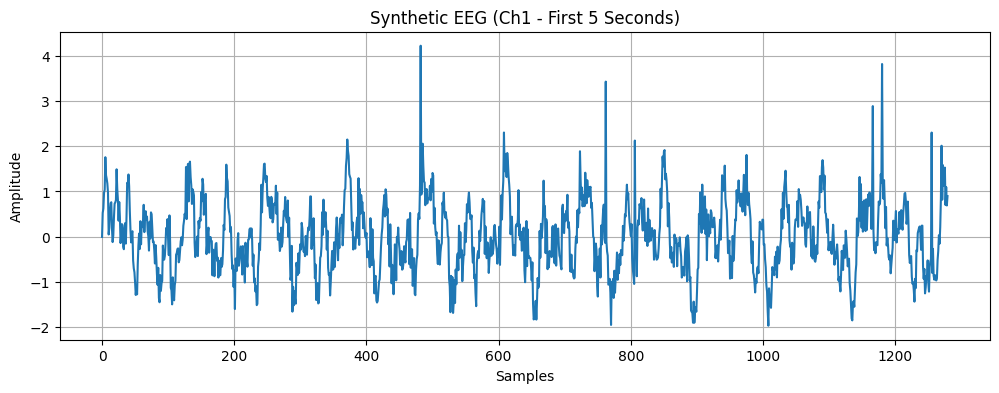

In [6]:
sfreq = 256  # samples per second
plt.figure(figsize=(12, 4))
plt.plot(eeg_df['Ch1'][:sfreq * 5])
plt.title("Synthetic EEG (Ch1 - First 5 Seconds)")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()



In [7]:
eeg_df.to_csv("synthetic_eeg.csv", index=False)
print("EEG data saved as 'synthetic_eeg.csv'")



EEG data saved as 'synthetic_eeg.csv'


In [8]:
from google.colab import files
files.download("synthetic_eeg.csv")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
from scipy.signal import butter, filtfilt, welch

# ---------------------------------------------
# EEG Band Definitions (reuse from above)
# ---------------------------------------------
EEG_BANDS = {
    "delta": (0.5, 4),
    "theta": (4, 8),
    "alpha": (8, 13),
    "beta": (13, 30)
}

# ---------------------------------------------
# Bandpass Filter Function
# ---------------------------------------------
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    """
    Apply Butterworth bandpass filter to EEG signal.

    Parameters:
        data (array): 1D EEG signal
        lowcut (float): Low frequency cut-off
        highcut (float): High frequency cut-off
        fs (float): Sampling frequency (Hz)
        order (int): Filter order

    Returns:
        filtered_data (array): Filtered signal
    """
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="band")
    return filtfilt(b, a, data)

# ---------------------------------------------
# Artifact Removal (Simple High Amplitude Spike Removal)
# ---------------------------------------------
def remove_artifacts(signal, threshold=5.0):
    """
    Replace values above threshold (z-score based) with mean.

    Parameters:
        signal (array): 1D EEG signal
        threshold (float): Z-score threshold

    Returns:
        clean_signal (array): Signal with high spikes reduced
    """
    z = (signal - np.mean(signal)) / np.std(signal)
    artifact_idx = np.where(np.abs(z) > threshold)[0]
    clean_signal = signal.copy()
    clean_signal[artifact_idx] = np.mean(signal)
    return clean_signal

# ---------------------------------------------
# PSD Calculation for All Bands
# ---------------------------------------------
def compute_band_psd(signal, fs=256):
    """
    Compute PSD and band powers.

    Parameters:
        signal (array): 1D EEG signal
        fs (float): Sampling frequency

    Returns:
        band_powers (dict): Power per band
    """
    freqs, psd = welch(signal, fs, nperseg=fs*2)
    band_powers = {}

    for band, (low, high) in EEG_BANDS.items():
        idx = np.logical_and(freqs >= low, freqs <= high)
        band_powers[band] = np.trapz(psd[idx], freqs[idx])

    return band_powers


In [10]:
pip install plotly


In [11]:
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display

# Dropdown to select EEG channel
channel_dropdown = widgets.Dropdown(
    options=eeg_df.columns,
    value='Ch1',
    description='Channel:',
    disabled=False,
)

# Dropdown to select band
band_dropdown = widgets.Dropdown(
    options=list(EEG_BANDS.keys()),
    value='alpha',
    description='Band:',
    disabled=False,
)

def plot_eeg_channel(ch_name, band):
    raw = eeg_df[ch_name].values
    filtered = butter_bandpass_filter(raw, *EEG_BANDS[band], sfreq)
    cleaned = remove_artifacts(filtered)

    fig = go.Figure()
    fig.add_trace(go.Scatter(y=cleaned[:sfreq*5], mode='lines', name='Filtered'))
    fig.update_layout(
        title=f"{ch_name} - {band} Band (First 5 seconds)",
        xaxis_title="Samples",
        yaxis_title="Amplitude",
        template="plotly_white"
    )
    fig.show()

widgets.interactive(plot_eeg_channel, ch_name=channel_dropdown, band=band_dropdown)


interactive(children=(Dropdown(description='Channel:', options=('Ch1', 'Ch2', 'Ch3', 'Ch4', 'Ch5', 'Ch6', 'Ch7…